This post implements a few measure of variable importance, interpreted as a key drivers analysis, for certain aspects of a payment card on customer satisfaction with that payment card.


_todo: replicate the table on slide 19 of the session 4 slides. This involves calculating pearson correlations, standardized regression coefficients, "usefulness", Shapley values for a linear regression, Johnson's relative weights, and the mean decrease in the gini coefficient from a random forest. You may use packages built into R or Python._

_If you want a challenge, either (1) implement one or more of the measures yourself. "Usefulness" is rather easy to program up. Shapley values for linear regression are a bit more work. Or (2) add additional measures to the table such as the importance scores from XGBoost._


In [99]:
import pandas as pd

data = pd.read_csv('data_for_drivers_analysis.csv')

data.head()

,brand,id,satisfaction,trust,build,differs,easy,appealing,rewarding,popular,service,impact
0,1,98,3,1,0,1,1,1,0,0,1,0
1,1,179,5,0,0,0,0,0,0,0,0,0
2,1,197,3,1,0,0,1,1,1,0,1,1
3,1,317,1,0,0,0,0,1,0,1,1,1
4,1,356,4,1,1,1,1,1,1,1,1,1


In [100]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2553 entries, 0 to 2552
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype
---  ------        --------------  -----
 0   brand         2553 non-null   int64
 1   id            2553 non-null   int64
 2   satisfaction  2553 non-null   int64
 3   trust         2553 non-null   int64
 4   build         2553 non-null   int64
 5   differs       2553 non-null   int64
 6   easy          2553 non-null   int64
 7   appealing     2553 non-null   int64
 8   rewarding     2553 non-null   int64
 9   popular       2553 non-null   int64
 10  service       2553 non-null   int64
 11  impact        2553 non-null   int64
dtypes: int64(12)
memory usage: 239.5 KB


In [101]:
data.describe()

,brand,id,satisfaction,trust,build,differs,easy,appealing,rewarding,popular,service,impact
count,2553.000000,2553.000000,2553.000000,2553.000000,2553.000000,2553.000000,2553.000000,2553.000000,2553.000000,2553.000000,2553.000000,2553.000000
mean,4.857423,8931.480611,3.386604,0.549550,0.461810,0.334508,0.536232,0.451234,0.451234,0.536232,0.467293,0.330983
std,2.830096,5114.287849,1.172006,0.497636,0.498637,0.471911,0.498783,0.497714,0.497714,0.498783,0.499027,0.470659
min,1.000000,88.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,3.000000,4310.000000,3.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,4.000000,8924.000000,4.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000
75%,6.000000,13545.000000,4.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
max,10.000000,18088.000000,5.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [102]:
data.brand.unique()

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10])

In [103]:
data.id.nunique()

940

In [104]:
data.shape

(2553, 12)

# Pearson Correlations

In [105]:
# Calculate pearson correlations with satisfaction being the y variable and the rest being the x variables

satisfaction = data.drop(['id', 'brand'], axis=1)

correlations = satisfaction.corr()['satisfaction'].sort_values(ascending=False)

# drop satisfaction from correlations

correlations = correlations.drop('satisfaction')

correlations = pd.DataFrame(correlations)



In [106]:

correlations = correlations.rename(columns={'satisfaction': 'Pearson_Corr'})


correlations['Pearson_Corr_%'] = round(correlations['Pearson_Corr']/correlations['Pearson_Corr'].sum(), 3)

# rename satisfaction column to Pearson_Corr

# drop PEARSON_CORR from correlations

correlations = correlations.drop('Pearson_Corr', axis=1)




In [107]:
data.columns

Index(['brand', 'id', 'satisfaction', 'trust', 'build', 'differs', 'easy',
       'appealing', 'rewarding', 'popular', 'service', 'impact'],
      dtype='object')

# Polychoric Correlations

In [108]:
import pandas as pd
import rpy2.robjects as robjects
from rpy2.robjects import pandas2ri

# Activate the pandas2ri conversion
pandas2ri.activate()


# Specify the columns of interest
columns_of_interest = ['trust', 'build', 'differs', 'easy', 'appealing', 'rewarding', 'popular', 'service', 'impact']

# Initialize a list to store the results
correlation = []

# Define the R code for calculating polychoric correlation
r_code = """
library(polycor)
polychoric_corr <- function(x, y) {
    result <- polychor(x, y)
    return(result)
}
"""

# Load the R code into the R environment
robjects.r(r_code)

# Get the polychoric_corr function
polychoric_corr = robjects.globalenv['polychoric_corr']

# Calculate polychoric correlations between 'satisfaction' and each specified column
for col in columns_of_interest:
    r_corr = polychoric_corr(data['satisfaction'], data[col])
    correlation.append(r_corr[0])

# Convert correlations to a pandas DataFrame
correlation_df = pd.DataFrame({
    'Variable': columns_of_interest,
    'Polychoric_Correlation': correlation
})

# Calculate the sum of the polychoric correlations
sum_polychoric_correlations = correlation_df['Polychoric_Correlation'].sum()

# Calculate the percentage of each polychoric correlation
correlation_df['Polychoric_Corr_Percent'] = (correlation_df['Polychoric_Correlation'] / sum_polychoric_correlations).round(3)

In [109]:
# make variable column the index

correlation_df.set_index('Variable', inplace=True)

In [110]:
# merge correlation_df with correlations

correlations = correlations.merge(correlation_df, left_index=True, right_index=True)

correlations

,Pearson_Corr_%,Polychoric_Correlation,Polychoric_Corr_Percent
trust,0.133,0.325066,0.129
impact,0.132,0.348443,0.138
service,0.130,0.327699,0.130
easy,0.111,0.273529,0.109
appealing,0.108,0.266616,0.106
rewarding,0.101,0.255609,0.101
build,0.100,0.249185,0.099
differs,0.096,0.251008,0.100
popular,0.089,0.223711,0.089


# Standardized Multiple Regression Coefficients

In [111]:
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression

# Initialize the StandardScaler

scaler = StandardScaler()

# Fit the scaler to the data

scaler.fit(data.drop(['id', 'brand', 'satisfaction'], axis=1))

# Transform the data

scaled_data = scaler.transform(data.drop(['id', 'brand', 'satisfaction'], axis=1))

# Convert the scaled data to a DataFrame

scaled_data = pd.DataFrame(scaled_data, columns=data.drop(['id', 'brand', 'satisfaction'], axis=1).columns)

# Add the 'satisfaction' column to the scaled data

scaled_data['satisfaction'] = data['satisfaction']

# Initialize the LinearRegression model

model = LinearRegression()

# Fit the model to the scaled data

model.fit(scaled_data.drop('satisfaction', axis=1), scaled_data['satisfaction'])

LinearRegression()

In [112]:
coefficients = model.coef_

In [113]:
correlations['Std_Coefficients'] = coefficients

In [114]:
scaled_data.head()

,trust,build,differs,easy,appealing,rewarding,popular,service,impact,satisfaction
0,0.905357,-0.926325,1.410483,0.929981,1.102790,-0.906791,-1.075291,1.067700,-0.703371,3
1,-1.104536,-0.926325,-0.708977,-1.075291,-0.906791,-0.906791,-1.075291,-0.936593,-0.703371,5
2,0.905357,-0.926325,-0.708977,0.929981,1.102790,1.102790,-1.075291,1.067700,1.421725,3
3,-1.104536,-0.926325,-0.708977,-1.075291,1.102790,-0.906791,0.929981,1.067700,1.421725,1
4,0.905357,1.079534,1.410483,0.929981,1.102790,1.102790,0.929981,1.067700,1.421725,4


In [115]:
# get standard deviation of each column in scaled_data

std_dev = scaled_data.std()

std_dev = pd.DataFrame(std_dev)

std_dev

,0
trust,1.000196
build,1.000196
differs,1.000196
easy,1.000196
appealing,1.000196
rewarding,1.000196
popular,1.000196
service,1.000196
impact,1.000196
satisfaction,1.172006


In [116]:
sat = std_dev.iloc[-1,-1]

sat

1.1720059326669825

In [117]:
# drop satisfaction from std_dev

std_dev = std_dev.drop('satisfaction')

In [118]:
# add coefficients to std_dev DataFrame



std_dev = std_dev.rename(columns={0: 'Standard_Deviation'})

std_dev['Coefficient'] = coefficients

std_dev

,Standard_Deviation,Coefficient
trust,1.000196,0.135635
build,1.000196,0.023411
differs,1.000196,0.032631
easy,1.000196,0.025744
appealing,1.000196,0.039647
rewarding,1.000196,0.005937
popular,1.000196,0.019470
service,1.000196,0.103573
impact,1.000196,0.150482


In [119]:
std_dev['Std_Coef'] = std_dev['Coefficient'] * std_dev['Standard_Deviation'] / sat

std_dev['Std_Coef_%'] = round(std_dev['Std_Coef'] / std_dev['Std_Coef'].sum(), 3)

std_dev

,Standard_Deviation,Coefficient,Std_Coef,Std_Coef_%
trust,1.000196,0.135635,0.115752,0.253
build,1.000196,0.023411,0.019979,0.044
differs,1.000196,0.032631,0.027847,0.061
easy,1.000196,0.025744,0.021970,0.048
appealing,1.000196,0.039647,0.033835,0.074
rewarding,1.000196,0.005937,0.005067,0.011
popular,1.000196,0.019470,0.016616,0.036
service,1.000196,0.103573,0.088390,0.193
impact,1.000196,0.150482,0.128422,0.280


In [120]:
# merge std_dev with correlations

correlations = correlations.merge(std_dev, left_index=True, right_index=True)

correlations

,Pearson_Corr_%,Polychoric_Correlation,Polychoric_Corr_Percent,Std_Coefficients,Standard_Deviation,Coefficient,Std_Coef,Std_Coef_%
trust,0.133,0.325066,0.129,0.135635,1.000196,0.135635,0.115752,0.253
impact,0.132,0.348443,0.138,0.023411,1.000196,0.150482,0.128422,0.280
service,0.130,0.327699,0.130,0.032631,1.000196,0.103573,0.088390,0.193
easy,0.111,0.273529,0.109,0.025744,1.000196,0.025744,0.021970,0.048
appealing,0.108,0.266616,0.106,0.039647,1.000196,0.039647,0.033835,0.074
rewarding,0.101,0.255609,0.101,0.005937,1.000196,0.005937,0.005067,0.011
build,0.100,0.249185,0.099,0.019470,1.000196,0.023411,0.019979,0.044
differs,0.096,0.251008,0.100,0.103573,1.000196,0.032631,0.027847,0.061
popular,0.089,0.223711,0.089,0.150482,1.000196,0.019470,0.016616,0.036


# Shapley Values for Linear Regression

In [121]:
data.columns

Index(['brand', 'id', 'satisfaction', 'trust', 'build', 'differs', 'easy',
       'appealing', 'rewarding', 'popular', 'service', 'impact'],
      dtype='object')

In [122]:
columns_of_interest

['trust',
 'build',
 'differs',
 'easy',
 'appealing',
 'rewarding',
 'popular',
 'service',
 'impact']

In [123]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor

# Load dataset

X = data[['trust', 'build', 'differs', 'easy',
       'appealing', 'rewarding', 'popular', 'service', 'impact']]
y = data['satisfaction']

# Train a model
model = LinearRegression()
model.fit(X, y)


LinearRegression()

The feature_perturbation option is now deprecated in favor of using the appropriate masker (maskers.Independent, or maskers.Impute)


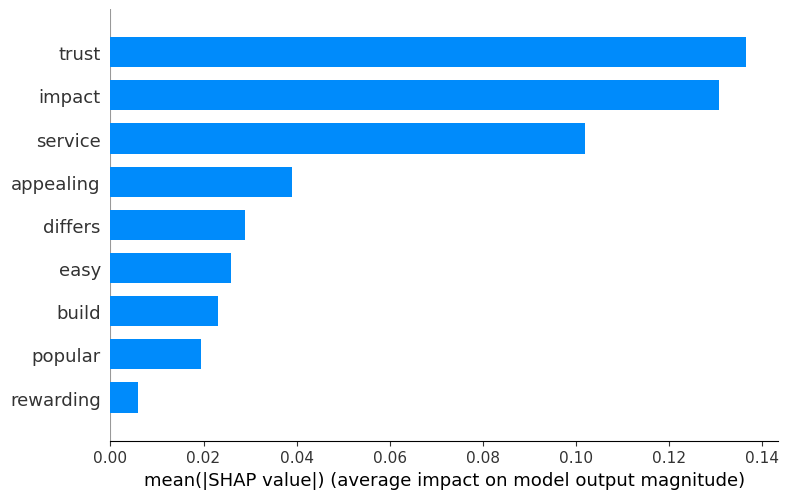

In [124]:
import shap

# Initialize SHAP explainer
explainer = shap.LinearExplainer(model, X, feature_perturbation="interventional")

# Calculate Shapley values
shap_values = explainer.shap_values(X)

# Plot the summary
shap.summary_plot(shap_values, X, plot_type="bar")




In [125]:
shap_values = pd.DataFrame(shap_values, columns=columns_of_interest)

# mean of absolute values of each column

shap_values_avg = shap_values.abs().mean()

shap_values_avg = pd.DataFrame(shap_values_avg)

shap_values_avg = shap_values_avg.rename(columns={0: 'Shapley_Value'})

In [126]:
correlations = correlations.merge(shap_values_avg, left_index=True, right_index=True)

In [127]:
correlations['Shapley_Value_%'] = round(correlations['Shapley_Value'] / correlations['Shapley_Value'].sum(), 3)

correlations

,Pearson_Corr_%,Polychoric_Correlation,Polychoric_Corr_Percent,Std_Coefficients,Standard_Deviation,Coefficient,Std_Coef,Std_Coef_%,Shapley_Value,Shapley_Value_%
trust,0.133,0.325066,0.129,0.135635,1.000196,0.135635,0.115752,0.253,0.136576,0.267
impact,0.132,0.348443,0.138,0.023411,1.000196,0.150482,0.128422,0.280,0.130708,0.255
service,0.130,0.327699,0.130,0.032631,1.000196,0.103573,0.088390,0.193,0.102030,0.199
easy,0.111,0.273529,0.109,0.025744,1.000196,0.025744,0.021970,0.048,0.025924,0.051
appealing,0.108,0.266616,0.106,0.039647,1.000196,0.039647,0.033835,0.074,0.039060,0.076
rewarding,0.101,0.255609,0.101,0.005937,1.000196,0.005937,0.005067,0.011,0.005861,0.011
build,0.100,0.249185,0.099,0.019470,1.000196,0.023411,0.019979,0.044,0.023157,0.045
differs,0.096,0.251008,0.100,0.103573,1.000196,0.032631,0.027847,0.061,0.028857,0.056
popular,0.089,0.223711,0.089,0.150482,1.000196,0.019470,0.016616,0.036,0.019465,0.038


# Johnson's Epilon

In [169]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
import numpy as np
from scipy.stats import johnsonsu
from sklearn.linear_model import LinearRegression


# Specify the predictor variables and the target variable
predictors = ['trust', 'build', 'differs', 'easy', 'appealing', 'rewarding', 'popular', 'service', 'impact']
target = 'satisfaction'

# Fit Johnson SU distribution to each predictor
johnson_params = {}
for col in predictors:
    params = johnsonsu.fit(data[col])
    johnson_params[col] = params

# Transform predictors using the fitted Johnson SU parameters
X_transformed = pd.DataFrame()
for col in predictors:
    gamma, delta, xi, lambda_ = johnson_params[col]
    transformed = johnsonsu.cdf(data[col], gamma, delta, xi, lambda_)
    X_transformed[col] = transformed

# Fit the linear regression model
model = LinearRegression()
model.fit(X_transformed, data[target])

# Display the model coefficients
johnson_coef = pd.DataFrame({
    'Predictor': predictors,
    'Johnson_Epsilon': model.coef_
})



In [170]:
johnson_coef = pd.DataFrame(johnson_coef)

johnson_coef.set_index('Predictor', inplace=True)

In [173]:
johnson_coef['Johnson_Epsilon_%'] = round(johnson_coef['Johnson_Epsilon'] / johnson_coef['Johnson_Epsilon'].sum(), 3)

correlations = correlations.merge(johnson_coef, left_index=True, right_index=True)

In [174]:
correlations

,Pearson_Corr,Pearson_Corr_%,Polychoric_Correlation,Polychoric_Corr_Percent,Standard_Deviation,Coefficient,Std_Coef,Std_Coef_%,Shapley_Value,Shapley_Value_%,Johnson_Epsilon,Johnson_Epsilon_%
trust,0.255706,0.133,0.325066,0.129,1.000196,0.135635,0.115752,0.253,0.126132,0.168,0.381407,0.253
impact,0.254539,0.132,0.348443,0.138,1.000196,0.150482,0.128422,0.280,0.162314,0.217,0.403438,0.268
service,0.251098,0.130,0.327699,0.130,1.000196,0.103573,0.088390,0.193,0.121793,0.163,0.399815,0.265
easy,0.212985,0.111,0.273529,0.109,1.000196,0.025744,0.021970,0.048,0.050894,0.068,0.052695,0.035
appealing,0.207997,0.108,0.266616,0.106,1.000196,0.039647,0.033835,0.074,0.068315,0.091,0.095863,0.064
rewarding,0.194561,0.101,0.255609,0.101,1.000196,0.005937,0.005067,0.011,0.047909,0.064,0.012569,0.008
build,0.191896,0.100,0.249185,0.099,1.000196,0.023411,0.019979,0.044,0.064744,0.086,0.049673,0.033
differs,0.184801,0.096,0.251008,0.100,1.000196,0.032631,0.027847,0.061,0.055374,0.074,0.070583,0.047
popular,0.171425,0.089,0.223711,0.089,1.000196,0.019470,0.016616,0.036,0.051395,0.069,0.039853,0.026


# Mean Decrease in RF Gini Coefficient

In [177]:
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(data[columns_of_interest], data['satisfaction'])

gini_importance = model.feature_importances_

# Create a DataFrame for better readability
feature_importance_df = pd.DataFrame({
    'Feature': columns_of_interest,
    'Gini Importance': gini_importance
})

# Sort the features by importance
feature_importance_df = feature_importance_df.sort_values(by='Gini Importance', ascending=False)

# Display the feature importances
print(feature_importance_df)

     Feature  Gini Importance
6    popular         0.135187
1      build         0.123719
5  rewarding         0.118519
2    differs         0.114670
3       easy         0.112496
4  appealing         0.107000
7    service         0.105882
8     impact         0.092704
0      trust         0.089825
